# Importing Libraries

In [1]:
import rasterio
import matplotlib.pyplot as plt

In [2]:
from rasterio.plot import show


In [3]:
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader

from torchgeo.datamodules import InriaAerialImageLabelingDataModule
from torchgeo.datasets import CDL, Landsat7, Landsat8, VHR10, stack_samples, Sentinel
from torchgeo.samplers import RandomGeoSampler
from torchgeo.trainers import SemanticSegmentationTask

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import xarray as xr

### Importing LandSAT8 data - Downloaded from the USGS website

In [5]:
# landsat7 = Landsat7(root="", bands=["B1", ..., "B7"])
iowa = Landsat8(root="..\\Data\\Remote Sensing\\LandSat\\Iowa", bands=["B1", "B2", "B3", "B4", "B5", "B6", "B7"])
kansas = Landsat8(root="..\\Data\\Remote Sensing\\LandSat\\Test", bands=["B1", "B2", "B3", "B4", "B5", "B6", "B7"])

In [6]:
satellite_data = iowa | kansas

Converting Landsat8 CRS from EPSG:32614 to EPSG:32615


### Importing CDL data - 2022

In [7]:
# Importing CDL data
cdl = CDL(root="..\\Data\\Remote Sensing\\CDL22")

### Creating a datasampler for the downloaded data

In [8]:
sampler = RandomGeoSampler(satellite_data, size=256, length=5)

In [9]:
sample = next(iter(sampler))
sample

BoundingBox(minx=-98075.56416102673, maxx=-90395.56416102673, miny=4109543.9120584833, maxy=4117223.9120584833, mint=1672167600.0, maxt=1672253999.999999)

#### Loading 256x256 patches from the datasampler

Sample is a dictionary with the following keys:
- 'image': A tensor of shape (256, 256, 7) containing the image
- 'BoundingBox'
- 'crs'

In [10]:
img_sample = satellite_data[sample]
img_sample

{'crs': CRS.from_epsg(32615),
 'bbox': BoundingBox(minx=-98075.56416102673, maxx=-90395.56416102673, miny=4109543.9120584833, maxy=4117223.9120584833, mint=1672167600.0, maxt=1672253999.999999),
 'image': tensor([[[ 7660.,  8880.,  8700.,  ...,  6508.,  7675.,  9721.],
          [ 5462.,  5991.,  6579.,  ...,  6983.,  7939.,  8750.],
          [ 3480.,  4385.,  5269.,  ...,  7194.,  8310.,  8376.],
          ...,
          [20289., 20340., 19626.,  ..., 13878., 13433., 12927.],
          [20354., 20429., 19684.,  ..., 13723., 13740., 13966.],
          [20105., 20237., 19892.,  ..., 13064., 13875., 15189.]],
 
         [[ 7173.,  8027.,  8338.,  ...,  8078.,  9369., 11807.],
          [ 5270.,  5814.,  6661.,  ...,  7998.,  9008., 10495.],
          [ 4634.,  5203.,  5874.,  ...,  8428.,  9138.,  9391.],
          ...,
          [20940., 20586., 20036.,  ..., 14700., 14072., 13572.],
          [21051., 20786., 20162.,  ..., 14561., 14253., 14120.],
          [20940., 20910., 20063.,  .

In [11]:
img_sample.keys()

dict_keys(['crs', 'bbox', 'image'])

### Shape of image

In [12]:
img_sample['image'].shape

torch.Size([7, 256, 256])

### Scaling images

In [13]:
def scale_image(item: dict):
    item['image'] = item['image'] * 0.0001
    return item

In [14]:
img_sample = scale_image(img_sample)

### Taking out RGB bands 3 - R, 2 - G, 1 - B

In [15]:
rgb = img_sample['image'][[3, 2, 1], :, :, ]

In [16]:
# convert rgb tensor to numpy array
rgb = rgb.numpy()

In [17]:
rgb = rgb.transpose(1, 2, 0)
rgb.shape


(256, 256, 3)

In [18]:
# clamp values to range [0, 1]
import numpy as np
rgb = np.clip(rgb, 0, 255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


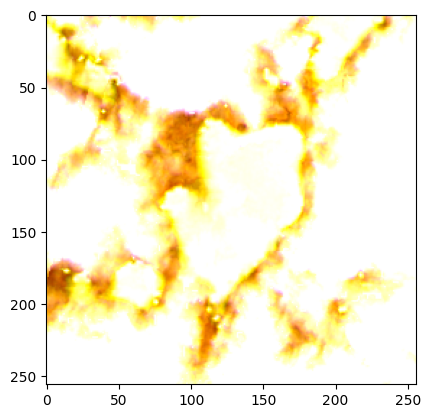

In [19]:
plt.imshow(rgb)

### TODO LIST:
- [x] Download Landsat8 data
- [x] Create a datasampler for the downloaded data
- [x] Load 256x256 patches from the datasampler
- [x] Scale images
- [x] Take out RGB bands 3 - R, 2 - G, 1 - B to plot
- [] Download Crop Data Layer (CDL) data
- [] Download more Landsat8 data
- [] Merge CDL data with Landsat8 data using TorchGeo's & operator
- [] Create a dataloader
- [] Create a model

In [50]:
# import rasterio
# from matplotlib import pyplot
# src = rasterio.open("..\Data\Remote Sensing\itqan.tif")
# pyplot.imshow(src.read(1))
# pyplot.show()

### Concatenated CDL data and Iowa Data

In [25]:
train_data = cdl & iowa

Converting Landsat8 CRS from EPSG:32615 to EPSG:5070


In [26]:
new_sampler = RandomGeoSampler(train_data, size=256, length=5)

In [27]:
sample = next(iter(new_sampler))

In [47]:
mask = train_data[sample]['mask'].numpy().transpose(1, 2, 0)

In [48]:
arb = scale_image(train_data[sample])
img = arb['image'][[3, 2, 1], :, :, ]
img = img.numpy()
img = img.transpose(1, 2, 0)
img.shape   

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


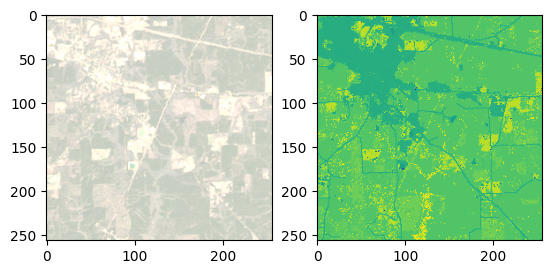

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax2.imshow(mask)